# Classification by Mechanism of Action

## Imports and Loading Data

In [1]:
# IMPORTS
# base
import pandas as pd
import numpy as np
from typing import Literal

# importing from scripts
from src.scripts import targets

# stats
import statsmodels.formula.api as smf

# plots
import seaborn as sns
from matplotlib import pyplot as plt

# remove warnings
import warnings

warnings.filterwarnings("ignore")

In [2]:
# select for cheng prusoff
usecols = [
    "Ki (nM)",
    "IC50 (nM)",
]

# load data
df = pd.read_csv(
    r"../data/BindingDB_All.tsv",
    sep="\t",
    usecols=usecols,
)

# clean data
df.replace(" NV,", np.nan, inplace=True)
for col in df.columns:
    df[col] = df[col].astype(str).str.replace(" C", "")
    df[col] = (
        df[col].astype(str).str.replace(">", "").str.replace("<", "").astype(float)
    )

## Classification Functions
The analytical derivation of these functions will soon be available...

In [3]:
from src.scripts import cheng_prusoff_classification as cp

# def cheng_prusoff_data(df: pd.DataFrame):
#     both = df[df["IC50 (nM)"].notna() & df["Ki (nM)"].notna()][["IC50 (nM)", "Ki (nM)"]]
#     both_log = both.apply(np.log)
#     both_log = both_log.rename(columns={"Ki (nM)": "log_Ki", "IC50 (nM)": "log_IC50"})
#     return both_log


# def cheng_prusoff_model(df: pd.DataFrame, random_state=11):
#     mod = smf.ols(formula="log_Ki ~ log_IC50", data=df)
#     np.random.seed(random_state)
#     res = mod.fit()
#     return res


# def cheng_prusoff_classifier(
#     df: pd.DataFrame,
#     min_seperator_interecpt: float = -5,
#     max_seperator_interecpt: float = 10,
#     metric: Literal["abs", "square"] = "square",
#     show_evaluation: bool = True,
# ):
#     # storage
#     b_range = []
#     slope_diff_range = []
#     int_diff_range = []

#     # linear seperator (y=mx+b)
#     m = 1  # set to 1 by loglog cheng-prussof derivation
#     for b in np.arange(min_seperator_interecpt, max_seperator_interecpt, 0.1):
#         # assign labels; cluster 1 = below line
#         df["label"] = (df["log_IC50"] < m * df["log_Ki"] + b).astype(int)
#         fam0 = df.query("label == 0")
#         fam1 = df.query("label == 1")

#         # model per cluster
#         res0 = cheng_prusoff_model(fam0)
#         res1 = cheng_prusoff_model(fam1)
#         m0, b0 = res0.params
#         m1, b1 = res1.params

#         b_range.append(b)
#         if metric == "square":
#             slope_diff_range.append(np.square(m0 - m1))
#             int_diff_range.append(np.square(b0 - b1))
#         elif metric == "abs":
#             slope_diff_range.append(np.abs(m0 - m1))
#             int_diff_range.append(np.abs(b0 - b1))
#         else:
#             raise ValueError("Metric must be either 'square' or 'abs'")

#     dists = np.array([slope_diff_range, int_diff_range]).T
#     dists = (dists - np.mean(dists, axis=0)) / np.std(dists, axis=0)
#     dists[
#         :, 0
#     ] *= (
#         -1
#     )  # invert slope distance bcs need to maximise intercept diff and minimise slope dist
#     distance_scores = {}
#     b_max = {}
#     # alpha: importance of having similar slopes (tradeoff)
#     # 1-alpha: importance of having different interecepts
#     for alpha in np.arange(0, 1, 0.01):
#         distance_score = alpha * dists[:, 0] + (1 - alpha) * dists[:, 1]
#         distance_scores[alpha] = distance_score
#         b_max[alpha] = b_range[np.argmax(distance_score)]

#     if show_evaluation:
#         fig = plt.figure()
#         fig.set_figheight(10)
#         fig.set_figwidth(10)
#         ax1 = plt.subplot2grid(shape=(2, 2), loc=(0, 0), colspan=1)
#         ax2 = plt.subplot2grid(shape=(2, 2), loc=(0, 1), colspan=1)
#         ax3 = plt.subplot2grid(shape=(2, 2), loc=(1, 0), colspan=2)
#         axs = [ax1, ax2, ax3]

#         axs[0].plot(b_range, dists[:, 0])
#         axs[0].set_title(
#             "Negative Standardised Distance\nin population Slopes", fontsize=10
#         )
#         axs[1].plot(b_range, dists[:, 1])
#         axs[1].set_title("Standardised Distance\nin population Intercepts", fontsize=10)
#         i = 0
#         for alpha in np.arange(0, 1, 0.01):
#             if i % 10 == 0:
#                 (line,) = axs[2].plot(
#                     b_range, distance_scores[alpha], label=rf"$\alpha$ = {alpha:.2f}"
#                 )
#                 axs[2].vlines(
#                     x=b_max[alpha],
#                     ymin=-4,
#                     ymax=2.3,
#                     color=line.get_color(),
#                     linestyle="--",
#                 )
#             i += 1
#         axs[2].set_title("Total Distance Score between Population")
#         plt.legend()
#         plt.show()
#     return b_max


# def cheng_prusoff_plot(
#     families: list[pd.DataFrame],
#     regs: list,
#     ax=None,
# ):
#     palettes = ["Reds_r", "Blues_r"]
#     colors = ["maroon", "midnightblue"]
#     n_families = len(families)

#     for idx, subdata in enumerate(
#         families
#     ):  # subdata is one cluster from the original overlapping data
#         # density lines
#         sns.kdeplot(
#             subdata[["log_Ki", "log_IC50"]].dropna(),
#             y="log_Ki",
#             x="log_IC50",
#             levels=7,
#             cmap=palettes[idx % n_families],
#             fill=False,
#             linewidths=0.7,
#             ax=ax,
#         )

#         # data points
#         sns.scatterplot(
#             subdata[["log_Ki", "log_IC50"]].dropna(),
#             y="log_Ki",
#             x="log_IC50",
#             s=1,
#             color=colors[idx % n_families],
#             ax=ax,
#         )

#         # model regression
#         if ax:
#             x = np.linspace(-10, 25, num=50)
#             b, a = regs[idx].params
#             adjr2 = regs[idx].rsquared_adj
#             ax.plot(
#                 x,
#                 a * x + b,
#                 color=colors[idx % n_families],
#                 linestyle="--",
#                 label=f"{a:.2f}x + {b:.2f} ($R^2_{{adj}}$ = {adjr2:.2f})",
#             )

## Initial Data with No Classification

In [4]:
# prepare data for cheng-prusoff
both_log = cp.cheng_prusoff_data(df)

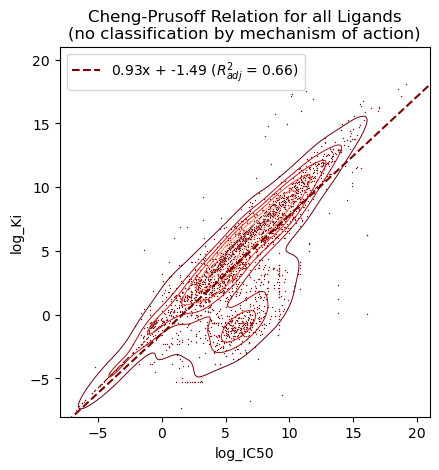

In [5]:
# model with no classification by mechanism of action
res = cp.cheng_prusoff_model(both_log)
fig, ax = plt.subplots(1, 1)
cp.cheng_prusoff_plot([both_log], [res], ax=ax)
ax.set_xlim(-8, 21)
ax.set_ylim(ax.get_xlim())
ax.set_aspect("equal", adjustable="box")
ax.set_title(
    "Cheng-Prusoff Relation for all Ligands\n(no classification by mechanism of action)"
)
ax.legend()
plt.show()

## Classification by Gaussian Mixture Models

In [6]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

ssc = StandardScaler().set_output(transform="pandas")
both_log_norm = ssc.fit_transform(both_log)
gmf = GaussianMixture(n_components=2, random_state=11)
both_log_norm["GMM"] = gmf.fit_predict(both_log_norm)

## seperate outliers from cluster
cluster_two = both_log_norm.query("GMM == 0")

gm2 = GaussianMixture(n_components=2, random_state=11)
cluster_two["GMM2"] = gm2.fit_predict(cluster_two)
cluster_two["GMM2"] -= 1


final = pd.concat([both_log_norm, cluster_two], axis=0).fillna(0)
final["cluster"] = final["GMM"] + final["GMM2"] + 1
final.drop(columns=["GMM", "GMM2"], inplace=True)

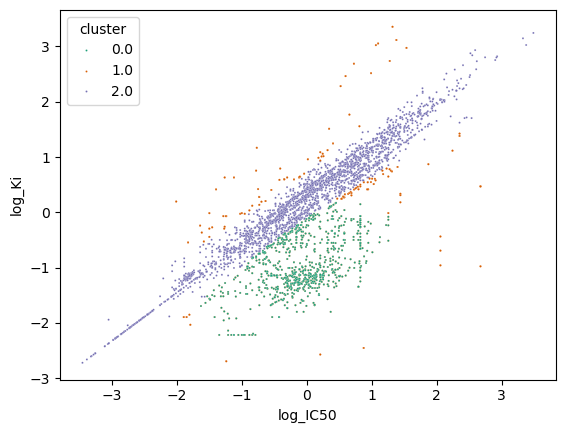

In [7]:
fig, axs = plt.subplots(1, 1)
sns.scatterplot(
    final,
    x="log_IC50",
    y="log_Ki",
    hue="cluster",
    s=2,
    ax=axs,
    palette="Dark2",
)
# lgnd = plt.legend(title='Cluster', loc='upper left', labels=['Non-comp', 'Comp', 'Outlier'])
plt.show()

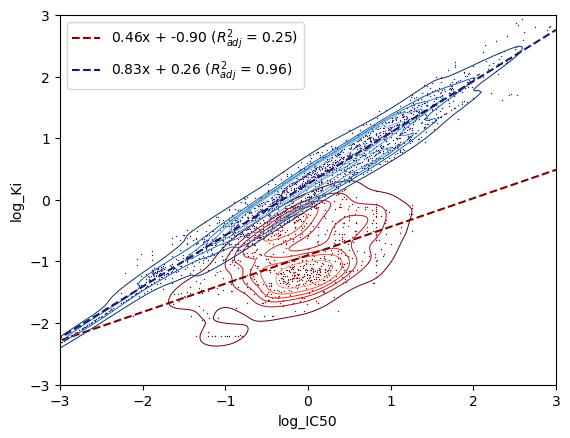

In [8]:
fam1 = final.query("cluster == 0")
fam2 = final.query("cluster == 2")
fam_out = final.query("cluster == 1")
fams = [fam1, fam2]

reg1 = cp.cheng_prusoff_model(fam1)
reg2 = cp.cheng_prusoff_model(fam2)
regs = [reg1, reg2]

fig, ax = plt.subplots(1, 1)
cp.cheng_prusoff_plot(fams, regs, ax=ax)
ax.set_xlim(-3, 3)
ax.set_ylim(ax.get_xlim())
plt.legend()
plt.show()

## Biochemically-informed Classification

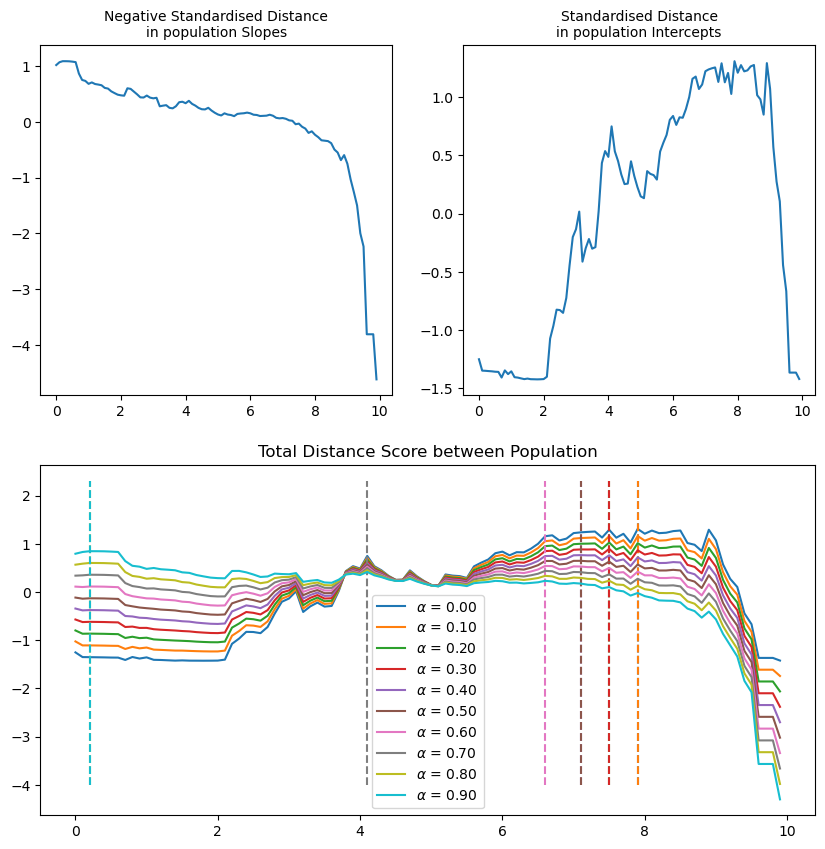

In [9]:
b_max = cp.cheng_prusoff_classifier(
    df=both_log, min_seperator_interecpt=0, show_evaluation=True
)

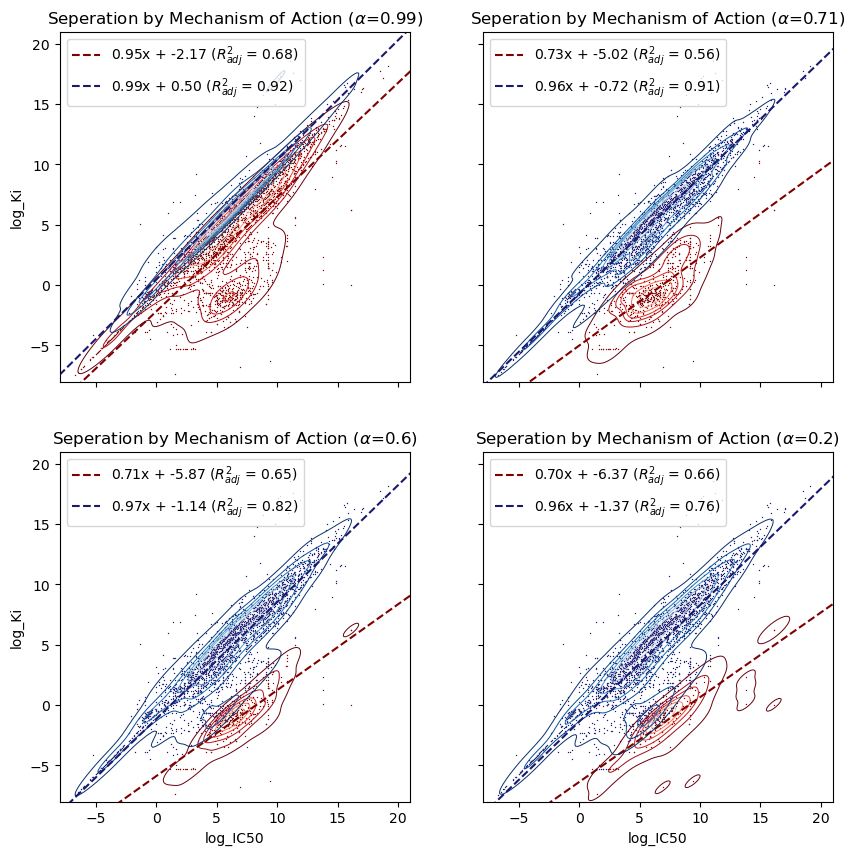

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
for alpha, ax in zip([0.99, 0.71, 0.6, 0.2], axs.flat):
    # results with optimal seperator
    m = 1
    b = b_max[alpha]

    # assign labels with optimal seperator intercept; cluster 1 = below line
    both_log["label"] = (both_log["log_IC50"] < m * both_log["log_Ki"] + b).astype(int)
    fam0 = both_log.query("label == 0")
    fam1 = both_log.query("label == 1")

    # model per cluster
    res0 = cp.cheng_prusoff_model(fam0)
    res1 = cp.cheng_prusoff_model(fam1)
    cp.cheng_prusoff_plot([fam0, fam1], [res0, res1], ax=ax)
    ax.set_xlim(-8, 21)
    ax.set_ylim(ax.get_xlim())
    ax.set_aspect("equal", adjustable="box")
    ax.set_title(rf"Seperation by Mechanism of Action ($\alpha$={alpha})")
    ax.legend()
plt.show()

## Further Analysis of Optimally Classified Data
The optimal mechanism of action is obtained through the biochemically-informed classifier described above, with an $\alpha$ parameter set to $\alpha$=0.71.

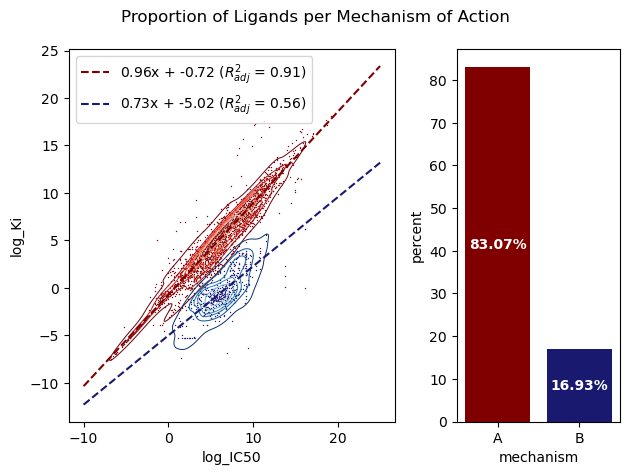

In [11]:
# assign labels with optimal seperator intercept; cluster 1 = below line
alpha = 0.71  # as found above
b = b_max[alpha]
classified_action = both_log.copy().drop(columns=["label"])
classified_action["mechanism"] = (both_log["log_IC50"] < both_log["log_Ki"] + b).astype(
    int
)
classified_action["mechanism"] = classified_action["mechanism"].replace(
    {1: "A", 0: "B"}
)
fam0 = classified_action.query("mechanism == 'A'")
fam1 = classified_action.query("mechanism == 'B'")

res0 = cp.cheng_prusoff_model(fam0)
res1 = cp.cheng_prusoff_model(fam1)

fig, axs = plt.subplots(1, 2, gridspec_kw={"width_ratios": [2, 1]})

cp.cheng_prusoff_plot([fam0, fam1], [res0, res1], ax=axs[0])
axs[0].legend()

sns.countplot(classified_action, x="mechanism", ax=axs[1], stat="percent")

colors = ["maroon", "midnightblue"]
for bar, color in zip(axs[1].patches, colors):
    bar.set_facecolor(color)
    count = bar.get_height()
    x = bar.get_x() + bar.get_width() / 2
    y = count / 2
    axs[1].text(
        x,
        y,
        f"{count:.2f}%",
        ha="center",
        va="center",
        fontweight="bold",
        color="white",
    )
fig.suptitle("Proportion of Ligands per Mechanism of Action")
plt.tight_layout()
plt.show()

Might be a banger explanation of observations, to be confirmed with timeseries:

"While competitive binding dominates, there is growing interest in allosteric modulators, which may bind uncompetitively or non-competitively."

DONE: h-index/metrics per mechanism

TODO: timeseries of mechanisms

(this is added in success per molecular features, as binding mechanisms are directly linked to molecular mechanisms)

### H-index and Average Citations per mechanism

In [12]:
dois = pd.read_csv(
    r"../data/BindingDB_All.tsv",
    sep="\t",
    usecols=["Article DOI"],
)

In [13]:
# prepare data
import json

with open("../src/data/citations.json", "r") as f:
    citations = json.load(f)
citations = pd.DataFrame(citations)
classified_dois = pd.merge(
    left=classified_action, right=dois, left_index=True, right_index=True
)
classified_citations = pd.merge(
    left=classified_dois,
    right=citations,
    left_on="Article DOI",
    right_on="doi",
    how="inner",
)  # note: around half the mechanisms are lost because don't have publication
# classified_citations["mechanism"].value_counts()/classified_citations["mechanism"].shape[0] #but proportion remains similar (89%-11%) --> ok for further analysis
classified_citations.drop(
    columns=["log_IC50", "log_Ki", "Article DOI", "doi"], inplace=True
)

In [14]:
# calculate h-index and avg citations
h_per_mech = cp.classified_h_index(classified_citations)
avg_cit_per_mech = (
    classified_citations.groupby("mechanism").sum()
    / classified_citations.groupby("mechanism").count()
).to_dict()["citation"]

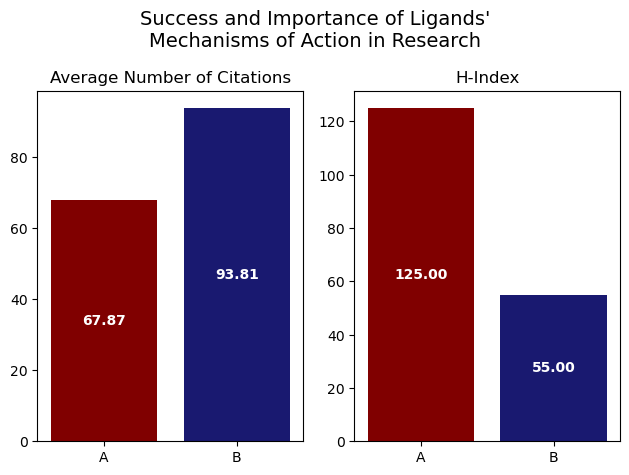

In [15]:
# plot results
fig, axs = plt.subplots(1, 2)

sns.barplot(avg_cit_per_mech, ax=axs[0])
axs[0].set_title("Average Number of Citations")
sns.barplot(h_per_mech, ax=axs[1])
axs[1].set_title("H-Index")


colors = ["maroon", "midnightblue"]
for ax in axs:
    for bar, color in zip(ax.patches, colors):
        bar.set_facecolor(color)
        count = bar.get_height()
        x = bar.get_x() + bar.get_width() / 2
        y = count / 2
        ax.text(
            x,
            y,
            f"{count:.2f}",
            ha="center",
            va="center",
            fontweight="bold",
            color="white",
        )
fig.suptitle(
    "Success and Importance of Ligands'\nMechanisms of Action in Research", fontsize=14
)
plt.tight_layout()
plt.show()